In [1]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 49kB/s 
     |████████████████████████████████| 3.1MB 28.7MB/s 
     |████████████████████████████████| 501kB 44.6MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-01-01 19:37:25--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-01-01 19:37:25 (3.23 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



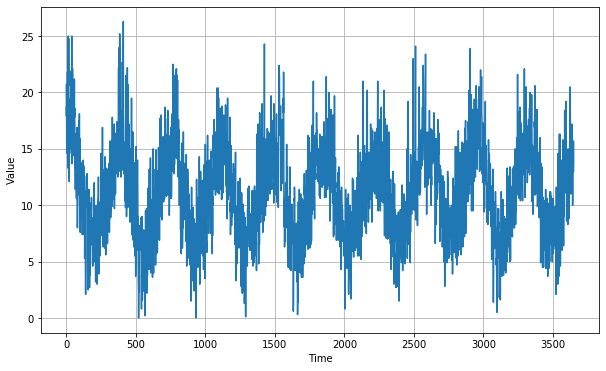

In [9]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[1])) # YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
    time_step.append(step)  # HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
    step = step + 1



series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:] 
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size +1 , shift = 1, drop_remainder = True)
    data = data.flat_map(lambda x : x.batch(window_size + 1))
    data = data.shuffle(shuffle_buffer)
    data = data.map(lambda x: (x[:-1],x[1:]))
    return data.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size, shift = 1, drop_remainder = True)
    data = data.flat_map(lambda x: x.batch(window_size))
    data = data.batch(32).prefetch(1)
    forecast = model.predict(data)
    return forecast 

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=32, kernel_size = 5, strides=1, padding='causal', activation='relu', input_shape = [None,1]),
tf.keras.layers.LSTM(64, activation= 'relu', return_sequences=True),
tf.keras.layers.LSTM(64, activation= 'relu', return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
# tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 7s 653ms/step - loss: 455.2284 - mae: 469.4294
Epoch 2/100
10/10 [==============================] - 4s 419ms/step - loss: 130.1448 - mae: 134.6080
Epoch 3/100
10/10 [==============================] - 4s 416ms/step - loss: 44.9369 - mae: 46.2053
Epoch 4/100
10/10 [==============================] - 4s 419ms/step - loss: 33.6479 - mae: 34.4954
Epoch 5/100
10/10 [==============================] - 4s 422ms/step - loss: 29.8541 - mae: 30.6505
Epoch 6/100
10/10 [==============================] - 4s 416ms/step - loss: 26.6809 - mae: 27.4624
Epoch 7/100
10/10 [==============================] - 4s 418ms/step - loss: 23.7513 - mae: 24.5177
Epoch 8/100
10/10 [==============================] - 4s 420ms/step - loss: 21.1420 - mae: 21.8875
Epoch 9/100
10/10 [==============================] - 4s 418ms/step - loss: 18.8673 - mae: 19.5879
Epoch 10/100

[1e-08, 0.0001, 0, 60]

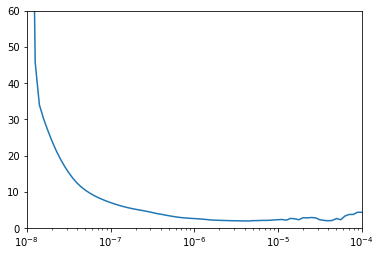

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=60, kernel_size = 5, strides=1, padding='causal', activation='relu', input_shape = [None,1]),
tf.keras.layers.LSTM(60, activation= 'relu', return_sequences=True),
tf.keras.layers.LSTM(60, activation= 'relu', return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
# tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x*400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs= 200)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/200
25/25 [==============================] - 6s 237ms/step - loss: 3.6837 - mae: 4.1870
Epoch 2/200
25/25 [==============================] - 4s 149ms/step - loss: 2.0714 - mae: 2.5288
Epoch 3/200
25/25 [==============================] - 4s 148ms/step - loss: 1.9294 - mae: 2.3841
Epoch 4/200
25/25 [==============================] - 4s 148ms/step - loss: 1.8565 - mae: 2.3091
Epoch 5/200
25/25 [==============================] - 4s 150ms/step - loss: 1.8121 - mae: 2.2635
Epoch 6/200
25/25 [==============================] - 4s 149ms/step - loss: 1.7774 - mae: 2.2271
Epoch 7/200
25/25 [==============================] - 4s 149ms/step - loss: 1.7487 - mae: 2.1976
Epoch 8/200
25/25 [==============================] - 4s 149ms/step - loss: 1.7253 - mae: 2.1737
Epoch 9/200
25/25 [==============================] - 4s 149ms/step - loss: 1.7005 - mae: 2.1480
Epoch 10/200
25/25 [==============================] - 4s 150ms/step - loss: 1.6766 - mae: 2.1231
Epoch 11/200
25/25 [===================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

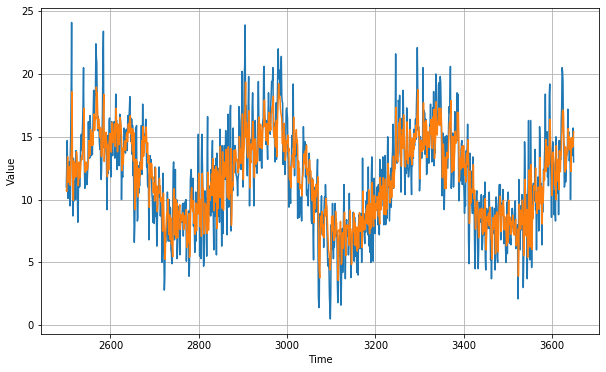

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8129103

In [22]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[10.752055 10.650495 12.260328 ... 14.27732  14.245539 15.395784]
